In [56]:
import pandas as pd
import json
from pathlib import Path
import re
import sys
sys.path.insert(0, '/home/sagemaker-user/compliance')
from compliance_utils import print_color

FOLDER_HOME: Path = Path('/home/sagemaker-user')
FOLDER_JUDGED_SCENARIOS: Path = FOLDER_HOME / 'data/judged_scenarios/'
FOLDER_JUDGED_SCENARIOS_CSV: Path = FOLDER_JUDGED_SCENARIOS / 'csv/'

In [40]:
def parse_filename(filename):
    parts = filename.replace('judged_scenarios_batch-scenarios-', '').replace('.json', '').split('-')
    complexity = parts[0]
    model = '-'.join(parts[3:-1])
    temp = parts[-1].replace('temp', '')
    
    print(f"Model: {model}")
    print(f"Temp: {temp}")
    print(f"Scenario Complexity: {complexity}")

In [47]:
def analyze_scenarios_in_json_files(folder_path):
    folder = Path(folder_path)
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
                
            print_color(f"\n\n{json_file.name}", 'cyan')
            parse_filename(json_file.name)
            print_color(f"Total={len(scenarios)}", 'blue')
            print("=" * 80)
            
            # Confusion matrix counters
            tp = fp = tn = fn = 0
            
            for scenario in scenarios:
                is_compliant = scenario.get('is-compliant')
                judged_compliant = scenario.get('judged-compliant')
                
                if is_compliant and judged_compliant:
                    tp += 1
                elif not is_compliant and judged_compliant:
                    fp += 1
                elif not is_compliant and not judged_compliant:
                    tn += 1
                elif is_compliant and not judged_compliant:
                    fn += 1
            
            
            print("Confusion Matrix:")
            print("                Predicted")
            print("Actual      Compliant  Non-Compliant")
            print("Compliant      " + f"\033[92m{tp:4d}\033[0m" + "       " + f"\033[95m{fn:4d}\033[0m")
            print("Non-Compliant  " + f"\033[95m{fp:4d}\033[0m" + "       " + f"\033[92m{tn:4d}\033[0m")

            print(f"% False Positive: {(fp/len(scenarios)):.1%}       % False Negative: {(fn/len(scenarios)):.1%}")

            print("=" * 80)
            
        except Exception as e:
            print_color(f"{json_file.name}: Error - {e}", 'red')


In [42]:
def json_to_csv(json_file: Path, csv_file_path: Path):
    """Convert JSON file to CSV"""
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Handle both formats: {"scenarios": [...]} or [...]
    scenarios = data.get('scenarios', data) if isinstance(data, dict) else data
    
    df = pd.DataFrame(scenarios)
    df.to_csv(csv_file_path, index=False)
    print(f"Converted {json_file_path} to {csv_file_path}")
    
    return csv_file_path


In [57]:
def concatenate_csv_files(input_path: Path, output_file_path: Path):
    """
    Concatenate all CSV files in a directory into one CSV file
    Usage: concatenate_csv_files(Path("/path/to/csv/files"), Path("/path/to/combined_output.csv"))
    """
    csv_files = list(input_path.glob("*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {input_path}")
        return
    
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dfs.append(df)
        print(f"Added {csv_file.name} ({len(df)} rows)")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.to_csv(output_file_path, index=False)
    
    print(f"Concatenated {len(csv_files)} files into {output_file_path} ({len(combined_df)} total rows)")
    return output_file_path


JSON Error in judged_scenarios_batch-scenarios-4-policies-each-claude_opus_4_5-temp0.0.json: Expecting ',' delimiter: line 1 column 59753 (char 59752)


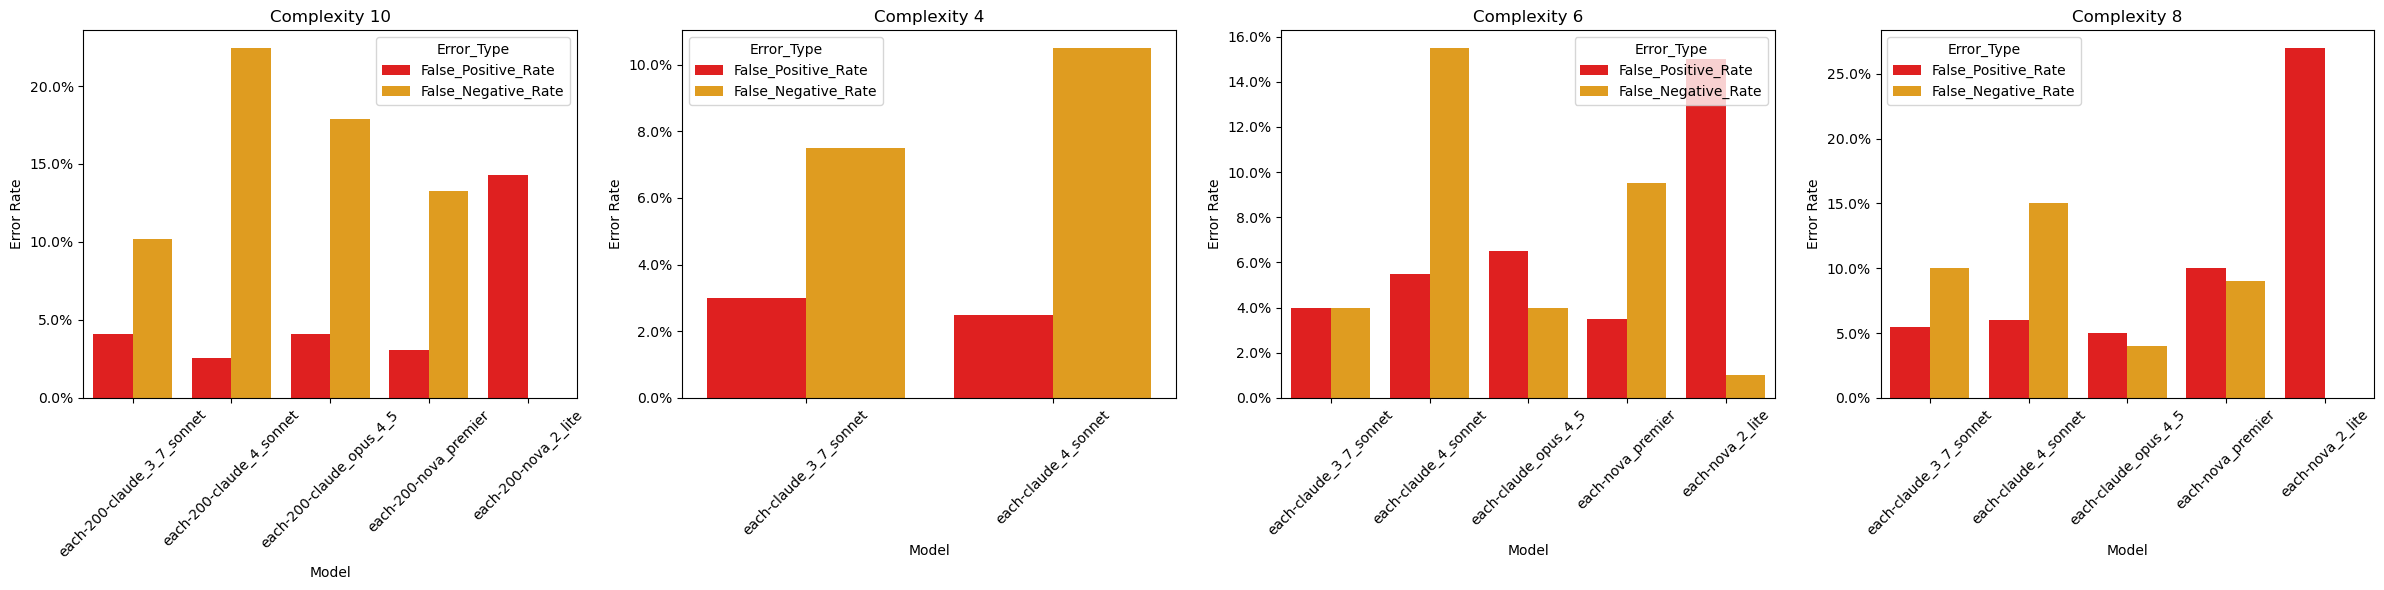

In [55]:
def collect_metrics_data(folder_path):
    results = []
    folder = Path(folder_path)
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
        except json.JSONDecodeError as e:
            print(f"JSON Error in {json_file.name}: {e}")
            continue
        
        # Parse filename - extract complexity from scenario filename
        parts = json_file.name.replace('judged_scenarios_batch-', '').replace('.json', '').split('-')
        
        # Extract complexity from "scenarios-X-policies-each" pattern
        complexity_match = re.search(r'scenarios-(\d+)-policies-each', json_file.name)
        complexity = complexity_match.group(1) if complexity_match else 'unknown'
        
        model = '-'.join(parts[3:-1])
        
        # Calculate metrics
        tp = fp = tn = fn = 0
        for scenario in scenarios:
            is_compliant = scenario.get('is-compliant')
            judged_compliant = scenario.get('judged-compliant')
            
            if is_compliant and judged_compliant: tp += 1
            elif not is_compliant and judged_compliant: fp += 1
            elif not is_compliant and not judged_compliant: tn += 1
            elif is_compliant and not judged_compliant: fn += 1
        
        results.append({
            'Model': model,
            'Complexity': complexity,
            'False_Positive_Rate': fp/len(scenarios),
            'False_Negative_Rate': fn/len(scenarios)
        })
    
    return pd.DataFrame(results)



import matplotlib.pyplot as plt
import seaborn as sns

# Create separate charts by complexity
df = collect_metrics_data("/home/sagemaker-user/data/judged_scenarios")
df_melted = df.melt(id_vars=['Model', 'Complexity'], 
                    value_vars=['False_Positive_Rate', 'False_Negative_Rate'],
                    var_name='Error_Type', value_name='Rate')

complexities = sorted(df['Complexity'].unique())
n_complexities = len(complexities)

fig, axes = plt.subplots(1, n_complexities, figsize=(6*n_complexities, 6))
if n_complexities == 1:
    axes = [axes]

for i, complexity in enumerate(complexities):
    data_subset = df_melted[df_melted['Complexity'] == complexity]
    
    sns.barplot(data=data_subset, x='Model', y='Rate', hue='Error_Type', 
                palette=['red', 'orange'], ax=axes[i])
    
    axes[i].set_title(f'Complexity {complexity}')
    axes[i].set_ylabel('Error Rate')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.tight_layout()
plt.show()


In [58]:
def main():

    analyze_scenarios_in_json_files("/home/sagemaker-user/data/judged_scenarios")
    
    # for json_file in Path(FOLDER_JUDGED_SCENARIOS).glob("*.json"):
    #     json_to_csv(json_file = json_file, csv_file_path = FOLDER_JUDGED_SCENARIOS_CSV)
    
    # concatenate_csv_files(input_path=FOLDER_JUDGED_SCENARIOS_CSV, output_file_path=FOLDER_JUDGED_SCENARIOS_CSV / "combined_output.csv")

In [59]:
main()



judged_scenarios_batch-scenarios-8-policies-each-claude_3_7_sonnet-temp0.1.json
Model: claude_3_7_sonnet
Temp: 0.1
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        80         20
Non-Compliant    11         89
% False Positive: 5.5%       % False Negative: 10.0%


judged_scenarios_batch-scenarios-8-policies-each-claude_4_sonnet-temp0.0.json
Model: claude_4_sonnet
Temp: 0.0
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        70         30
Non-Compliant    12         88
% False Positive: 6.0%       % False Negative: 15.0%


judged_scenarios_batch-scenarios-8-policies-each-claude_opus_4_5-temp0.0.json
Model: claude_opus_4_5
Temp: 0.0
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        92          8
Non-Compliant    10         90
% False Positive: 5.0% 